# Discoverling Morse Code Decoder

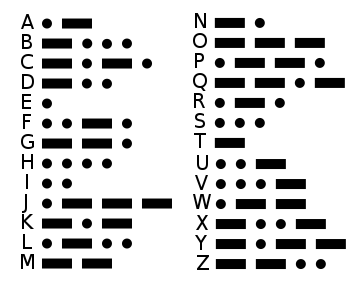


In [1]:
import classifier
import morse_client

# Morse client settings
broker = 'mqtt.eclipseprojects.io'
port = 1883
topic = "discoverling/mqtt"

# Load training data from the specified subfolder
classifier, classmap = classifier.load_classifier('training_data')

# Connect our MQTT client to the broker
client = morse_client.connect_mqtt(broker, port)

# Subscribe to the MQTT topic
morse_client.subscribe(client, topic)

# Start client loop, i.e. listening for incoming MQTT messages
morse_client.loop_start(client)

Loading training data...
Loading classifier...


In [ ]:
# Start decoding incoming morse code
morse_client.decode_morse(classifier, classmap)

Connected to MQTT Broker!
n 

a 

b 



In [ ]:
# Train a machine-learning model to classify Morse code input
#
# Requirements
# - SciKit-Learn to create the model (tested with v1.2.0)
# - MicroMLGen to export it in Arduino-usable C code (tested with v1.1.28)
#
# These dependencies can be installed from command-line as follows:
# pip install -U scikit-learn
# pip install micromlgen

# For loading training dataset from .csv files
import numpy as np
from glob import glob
from os.path import basename
# Import chosen classifier function
# (for alternatives see https://github.com/eloquentarduino/micromlgen)
from sklearn.ensemble import RandomForestClassifier

# Load training dataset from csv files 
def load_features(folder):
    dataset = None
    classmap = {}
    for class_idx, filename in enumerate(glob('%s/*.csv' % folder)):
        class_name = basename(filename)[:-4]
        classmap[class_idx] = class_name
        samples = np.loadtxt(filename, dtype=float, delimiter=',')
        labels = np.ones((len(samples), 1)) * class_idx
        samples = np.hstack((samples, labels))
        dataset = samples if dataset is None else np.vstack((dataset, samples))
    return dataset, classmap


# Load training data from the specified subfolder
features, classmap = load_features('training_data')

print(classmap)
# Create classifier function from feature set
X, y = features[:, :-1], features[:, -1]
classifier = RandomForestClassifier(20, max_depth=10).fit(X, y)

In [ ]:
import random
import time
from paho.mqtt import client as mqtt_client

broker = 'mqtt.eclipseprojects.io'
port = 1883
topic = "discoverling/test"
client_id = f'publish-{random.randint(0, 1000)}'


def connect_mqtt():
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connected to MQTT Broker!")
        else:
            print("Failed to connect, return code %d\n", rc)

    client = mqtt_client.Client(client_id)
    # client.username_pw_set(username, password)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

def publish(client):
    msg_count = 1
    while True:
        time.sleep(1)
        msg = f"messages: {msg_count}"
        result = client.publish(topic, msg)
        # result: [0, 1]
        status = result[0]
        if status == 0:
            print(f"Send `{msg}` to topic `{topic}`")
        else:
            print(f"Failed to send message to topic {topic}")
        msg_count += 1
        if msg_count > 5:
            break

def disconnect(client):
    client.loop_stop()
    client.disconnect()
    time.sleep(0.1)

def subscribe(client: mqtt_client):
        
    client.subscribe(topic)
    client.on_message = on_message



In [ ]:
intraCharacterPause = 0.5
timeout_period = 1.5
char_count = 0
button_time = 0
new_char_received = False


def on_message(client, userdata, msg):
    global char_count
    global button_time
    global new_char_received
    new_char_received = True
    button_time = int(msg.payload.decode())
    char_count += 1
    print(f"Received `{button_time}` from `{msg.topic}` topic")


def decode_morse(): 
    global char_count
    global button_time
    global new_char_received
    last_received_time = 0
    char_array = [0, 0, 0, 0]
    
    while True:
        current_time = time.time()   
        
        if new_char_received:
            print("New char received. char_count = {}".format(char_count))
            if char_count > 0: 
                if char_count == 1:
                    last_received_time = current_time
                print("current_time - last_received_time - button_time = {}".format(current_time - last_received_time))
                if current_time - last_received_time - button_time < intraCharacterPause:
                    char_array[char_count-1] = button_time 
                    last_received_time = current_time  # Update the timestamp
                else:
                    char_count = 4                
            if char_count == 4:
                print("Reached 4 characters. Predicting...")
                print("char_array = {}".format(char_array))
                class_prediction = classifier.predict([char_array])
                print("Class prediction = {}".format(class_prediction[0]))
                print("Class = {}".format(classmap[class_prediction[0]]))
                char_count = 0
                char_array = [0, 0, 0, 0]
            new_char_received = False
        else:
            # Check for timeout event when no new characters were received in time
            if current_time - last_received_time > timeout_period and char_count > 0: 
                char_count = 0 # Reached end of character
                print("TIMEOUT EVENT. Predicting...")
                print("char_array = {}".format(char_array))
                class_prediction = classifier.predict([char_array])
                print("Class prediction = {}".format(class_prediction[0]))
                print("Class = {}".format(classmap[class_prediction[0]]))
                
            
        time.sleep(0.2)


In [ ]:
client = connect_mqtt()
subscribe(client)
client.loop_start()

In [ ]:
decode_morse()

In [ ]:
disconnect(client)

In [ ]:
a = [150.00,1000.00,0.00,0.00]
b = [538.00,191.00,183.00,193.00]
class_prediction = classifier.predict([a])
print("Class prediction: {}".format(classmap[class_prediction[0]]))




In [ ]:

"""
def decode_morse():   
    last_received_time = 0
    
    while True:
 
        current_time = time.time()   
        
        if current_time - last_received_time < const_intraCharacterPause:
            if char_count > 0:   
                char_array[char_count-1] = button_time
                char_count += 1  
                last_received_time = current_time  # Update the timestamp
            if char_count == 4:
                class_prediction = classifier.predict([char_array])
                print("Reached 4 characters. Predicting...")
                print("char_array = {}".format(char_array))
                print("Class prediction = {}".format(class_prediction))
                char_count = 0
                char_array = [0, 0, 0, 0]
        else:
            if char_count == 0:
                continue
            else:
                class_prediction = classifier.predict([char_array])
                print("Failed to reach 4 characters. Predicting...")
                print("char_array = {}".format(char_array))
                print("Class prediction = {}".format(class_prediction))
                char_count = 0
                char_array = [0, 0, 0, 0]
                
        time.sleep(0.2)
        """